**Bloque 1: Carga del dataset y configuración inicial**

Objetivo: Descargar el dataset Superstore.xlsx, cargarlo en el lakehouse, configurar MLflow para el rastreo del experimento, y leer los datos en un DataFrame de Pandas.

Contexto:

Descargaremos el archivo Superstore.xlsx desde una URL pública y lo almacenaremos en el lakehouse.
Configuraremos MLflow para rastrear el experimento aisample-superstore-forecast.
Cargaremos los datos usando Pandas, ya que el archivo está en formato Excel.

In [1]:
# Bloque 1: Carga del dataset y configuración inicial
# Descargamos el dataset, configuramos MLflow y leemos los datos.

import os
import requests
import time
import mlflow
import pandas as pd

# Definir parámetros
IS_CUSTOM_DATA = False
IS_SAMPLE = False
SAMPLE_ROWS = 5000
DATA_ROOT = "/lakehouse/default"
DATA_FOLDER = "Files/salesforecast"
DATA_FILE = "Superstore.xlsx"
EXPERIMENT_NAME = "aisample-superstore-forecast"

# Descargar el dataset y almacenarlo en el lakehouse
if not IS_CUSTOM_DATA:
    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/Forecast_Superstore_Sales"
    file_list = ["Superstore.xlsx"]
    download_path = f"{DATA_ROOT}/{DATA_FOLDER}/raw"

    if not os.path.exists(DATA_ROOT):
        raise FileNotFoundError("Default lakehouse not found, please add a lakehouse and restart the session.")
    os.makedirs(download_path, exist_ok=True)
    for fname in file_list:
        if not os.path.exists(f"{download_path}/{fname}"):
            r = requests.get(f"{remote_url}/{fname}", timeout=30)
            with open(f"{download_path}/{fname}", "wb") as f:
                f.write(r.content)
    print("Dataset descargado en el lakehouse en Files/salesforecast/raw/.")

# Registrar el tiempo de inicio
ts = time.time()

# Configurar MLflow para el rastreo del experimento
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)
print("Configuración de MLflow completada.")

# Leer el dataset desde el lakehouse
df = pd.read_excel(f"{DATA_ROOT}/{DATA_FOLDER}/raw/{DATA_FILE}")
print("Dataset cargado con éxito.")

StatementMeta(, 3bb0b8a4-9503-415e-8bdf-019103c9ddb4, 3, Finished, Available, Finished)

2025/05/16 21:03:45 INFO mlflow.tracking.fluent: Experiment with name 'aisample-superstore-forecast' does not exist. Creating a new experiment.


Configuración de MLflow completada.
Dataset cargado con éxito.


**Bloque 2: Análisis exploratorio de datos (EDA)**

Objetivo: Realizar un análisis exploratorio del dataset, preprocesar los datos para enfocarnos en la categoría "Furniture", y visualizar componentes de la serie temporal para entender patrones.

Contexto:

Mostraremos una vista previa del dataset para entender su estructura.
Filtraremos los datos para la categoría "Furniture" y eliminaremos columnas innecesarias.
Agruparemos las ventas por fecha de pedido (Order Date) y las resamplingaremos a nivel mensual.
Visualizaremos la serie temporal y descompondremos sus componentes (tendencia, estacionalidad, residuales) para identificar patrones.

StatementMeta(, 3bb0b8a4-9503-415e-8bdf-019103c9ddb4, 4, Finished, Available, Finished)

Vista previa del dataset:


SynapseWidget(Synapse.DataFrame, c8f31296-7282-463b-8bbd-98b23cdabb5a)

Rango de fechas para Furniture: 2014-01-06 00:00:00 2017-12-30 00:00:00
Valores nulos en Furniture: Order Date    0
Sales         0
dtype: int64
Impacto de la fecha en las ventas:


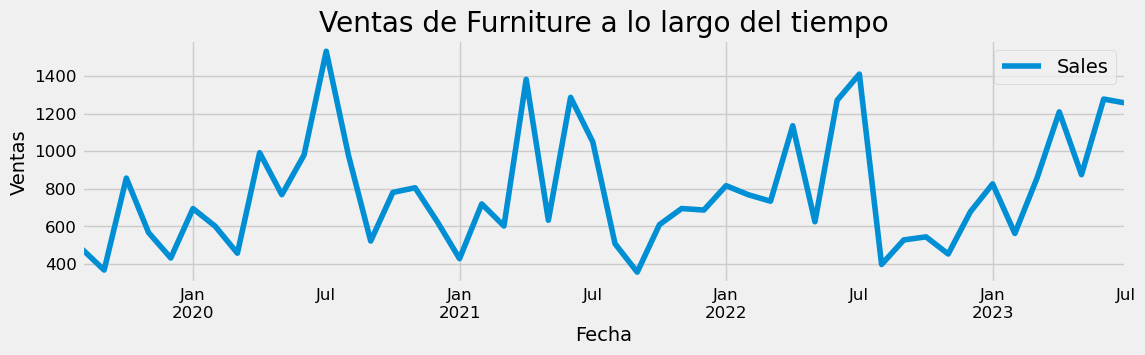

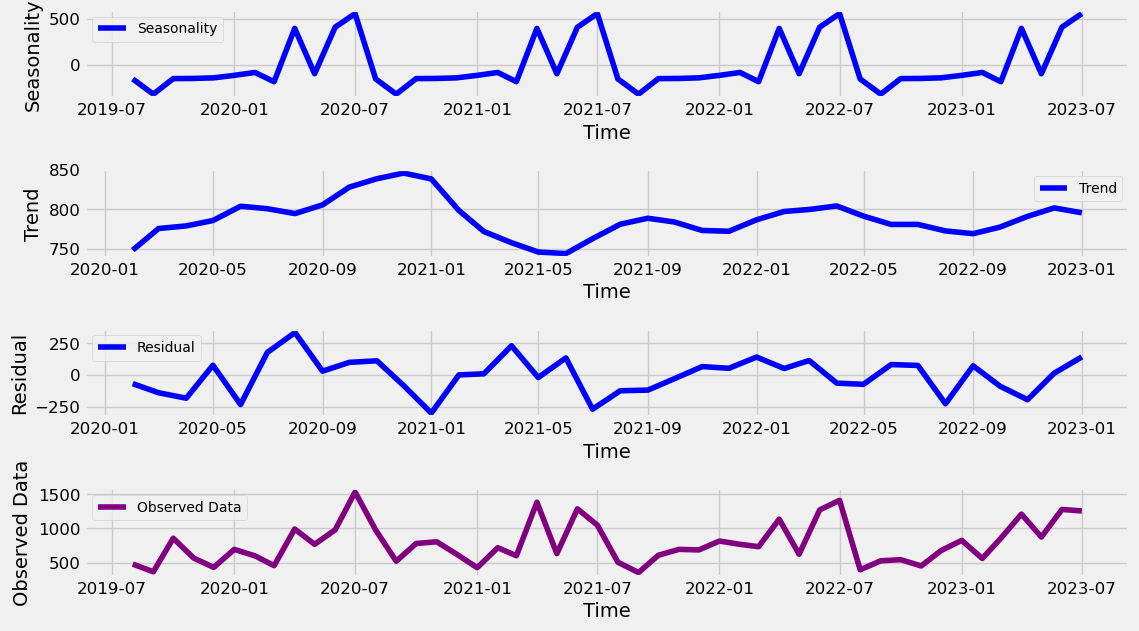

In [2]:
# Bloque 2: Análisis exploratorio de datos (EDA)
# Exploramos los datos, preprocesamos y visualizamos componentes de la serie temporal.

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import mlflow

# Mostrar una vista previa del dataset
print("Vista previa del dataset:")
display(df.head())

# Filtrar la categoría "Furniture"
furniture = df.loc[df['Category'] == 'Furniture']
print("Rango de fechas para Furniture:", furniture['Order Date'].min(), furniture['Order Date'].max())

# Preprocesamiento: eliminar columnas innecesarias y ordenar por fecha
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 
        'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 
        'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
print("Valores nulos en Furniture:", furniture.isnull().sum())

# Agrupar por fecha y resampling a nivel mensual
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
y = furniture['Sales'].resample('MS').mean()
y = y.reset_index()
y['Order Date'] = pd.to_datetime(y['Order Date'])
y['Order Date'] = [i + pd.DateOffset(months=67) for i in y['Order Date']]
y = y.set_index(['Order Date'])
maximim_date = y.reset_index()['Order Date'].max()

# Visualizar el impacto de la fecha en las ventas
print("Impacto de la fecha en las ventas:")
with mlflow.start_run(run_name="Sales Visualization"):
    y.plot(figsize=(12, 3))
    plt.title("Ventas de Furniture a lo largo del tiempo")
    plt.xlabel("Fecha")
    plt.ylabel("Ventas")
    plt.savefig("/tmp/sales_over_time.png")
    plt.show()
    mlflow.log_artifact("/tmp/sales_over_time.png")

# Descomposición de la serie temporal
result = sm.tsa.seasonal_decompose(y, model='additive')
components = [('Seasonality', result.seasonal),
              ('Trend', result.trend),
              ('Residual', result.resid),
              ('Observed Data', y)]
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.8)
axes = axes.ravel()

with mlflow.start_run(run_name="Time Series Decomposition"):
    for ax, (label, data) in zip(axes, components):
        ax.plot(data, label=label, color='blue' if label != 'Observed Data' else 'purple')
        ax.set_xlabel('Time')
        ax.set_ylabel(label)
        ax.legend(fontsize=10)
    plt.savefig("/tmp/decomposition_plots.png")
    plt.show()
    mlflow.log_artifact("/tmp/decomposition_plots.png")

**Bloque 3: Entrenamiento y ajuste del modelo SARIMAX**

Objetivo: Ajustar los hiperparámetros del modelo SARIMAX, entrenar el modelo con los mejores parámetros, y visualizar las predicciones para los próximos 6 meses.

Contexto:

Ajustaremos los hiperparámetros del modelo SARIMAX (p, d, q) y (P, D, Q, s) usando una búsqueda de cuadrícula y el criterio AIC.
Entrenaremos el modelo con los mejores parámetros (order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).
Visualizaremos las predicciones para los próximos 6 meses junto con los intervalos de confianza.

StatementMeta(, 3bb0b8a4-9503-415e-8bdf-019103c9ddb4, 5, Finished, Available, Finished)

Ejemplos de combinaciones de parámetros para SARIMAX:
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1452.263087433077


ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130919809


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793746


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1182.106357440832


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803020546


ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758095


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2722.9158699171235


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809158


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673299


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.58197805197216


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2438.546919593606


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946869


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.872557651997


ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668414504


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1449.1049459198691


ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785672006554


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:304.96712281679584


ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.7889663004408


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1377.7607191421034


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109212


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:306.9113200151421


ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817296


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2604.140372595292


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482611


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.5806233345346


ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.18329774427633


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2339.361854825847


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417331


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.5576621461233


ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067713


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1498.4704242123375


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.2077675160944


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935199


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1514.0023206739443


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.46646750845593


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.58426921438803


ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.779444218629


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2542.2552720089316


ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195815029


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.34221939659125


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323876707


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2430.901824258794


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.01560021330596


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.7513188134306


ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1460.2802866553911


ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281135


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.21306116191096


ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658784406


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1090.8603798878949


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.62709013454264


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:302.3264992504017


ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019834991


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1418.410783262933


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.4762687610734


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.3873006939364


ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.5250354660796


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2559.942953449445


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.78754395410476


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.366101439962


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   4099.182     -0.000      1.000   -8035.248    8033.248
ma.S.L12      -3.2470      1.669     -1.945      0.052      -6.518       0.025
sigma2      2368.6737   9.71e+06      0.000      1.000    -1.9e+07     1.9e+07


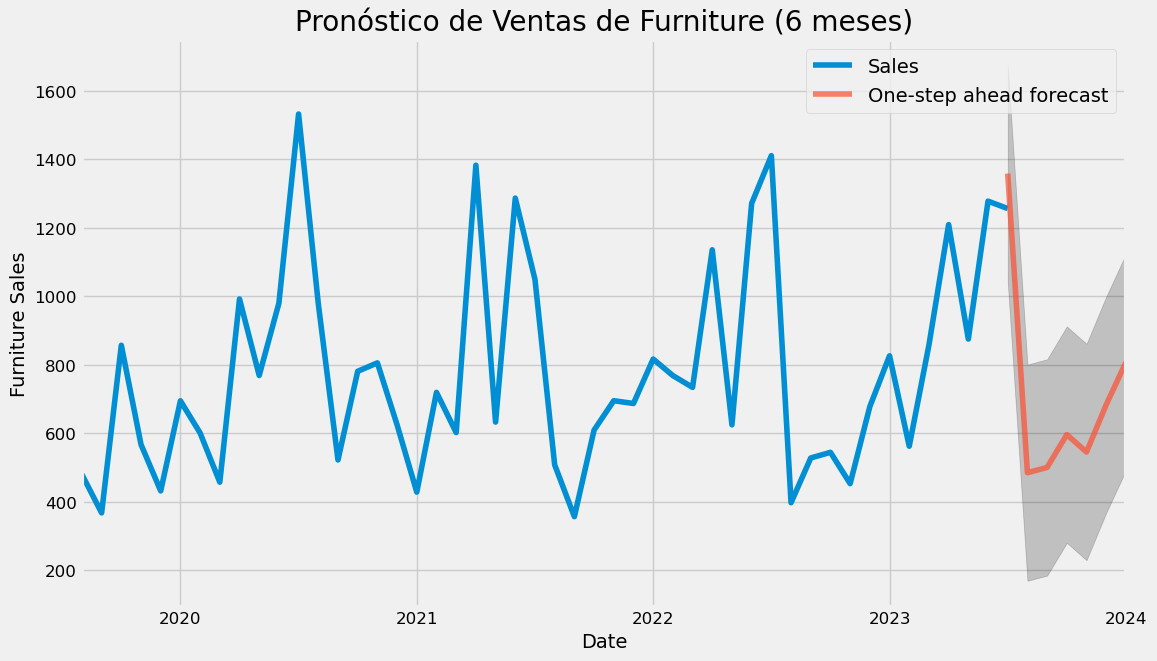

Successfully registered model 'aisample-superstore-forecast-Sarimax'.


Modelo guardado en run: cbf885be-c6cc-49b7-9503-a8a1468e4bf2
URI del modelo: runs:/cbf885be-c6cc-49b7-9503-a8a1468e4bf2/aisample-superstore-forecast-Sarimax


In [3]:
# Bloque 3: Entrenamiento y ajuste del modelo SARIMAX
# Ajustamos hiperparámetros, entrenamos el modelo y visualizamos predicciones.

import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import mlflow

# Ajuste de hiperparámetros
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print("Ejemplos de combinaciones de parámetros para SARIMAX:")
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

# Búsqueda de los mejores hiperparámetros basados en AIC
best_aic = float("inf")
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            with mlflow.start_run(run_name=f"SARIMAX_{param}x{param_seasonal}"):
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit(disp=False)
                aic = results.aic
                print(f'ARIMA{param}x{param_seasonal}12 - AIC:{aic}')
                mlflow.log_metric("AIC", aic)
                if aic < best_aic:
                    best_aic = aic
                    best_params = param
                    best_seasonal_params = param_seasonal
        except:
            continue

print(f"Mejores parámetros: ARIMA{best_params}x{best_seasonal_params}12 - AIC:{best_aic}")

# Entrenamiento del modelo con los mejores parámetros
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(disp=False)
print("Resumen del modelo SARIMAX:")
print(results.summary().tables[1])

# Visualizar las predicciones para los próximos 6 meses
with mlflow.start_run(run_name="Forecast Visualization"):
    pred = results.get_prediction(start=maximim_date, end=maximim_date + pd.DateOffset(months=6), dynamic=False)
    pred_ci = pred.conf_int()
    ax = y['2019':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7, figsize=(12, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Furniture Sales')
    plt.legend()
    plt.title("Pronóstico de Ventas de Furniture (6 meses)")
    plt.savefig("/tmp/forecast_plot.png")
    plt.show()
    mlflow.log_artifact("/tmp/forecast_plot.png")

# Guardar el modelo en MLflow
model_name = f"{EXPERIMENT_NAME}-Sarimax"
with mlflow.start_run(run_name="Final Model"):
    mlflow.statsmodels.log_model(results, model_name, registered_model_name=model_name)
    mlflow.log_params({"order": (0, 1, 1), "seasonal_order": (0, 1, 1, 12), 'enforce_stationarity': False, 'enforce_invertibility': False})
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/{model_name}"
    print("Modelo guardado en run:", mlflow.active_run().info.run_id)
    print(f"URI del modelo: {model_uri}")

**Bloque 4: Evaluación del modelo y almacenamiento de predicciones**

Objetivo: Evaluar el modelo SARIMAX calculando el MAPE, combinar las predicciones con los datos reales, y guardar los resultados para visualización en Power BI.

Contexto:

Calcularemos el MAPE (Mean Absolute Percentage Error) para evaluar la precisión del modelo en los últimos 6 meses de datos observados.
Combinaremos las ventas reales y pronosticadas, incluyendo las predicciones futuras (próximos 6 meses).
Guardaremos los resultados como una tabla Delta para uso en Power BI.

In [4]:
# Bloque 4: Evaluación del modelo y almacenamiento de predicciones
# Evaluamos el modelo con MAPE y guardamos los resultados para Power BI.

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
import mlflow

# Validar el modelo: calcular predicciones para los últimos 6 meses y los próximos 6 meses
predictions = results.get_prediction(start=maximim_date - pd.DateOffset(months=6-1), dynamic=False)
predictions_future = results.get_prediction(start=maximim_date + pd.DateOffset(months=1), 
                                           end=maximim_date + pd.DateOffset(months=6), dynamic=False)

# Preparar datos para Power BI
Future = pd.DataFrame(predictions_future.predicted_mean).reset_index()
Future.columns = ['Date', 'Forecasted_Sales']
Future['Actual_Sales'] = np.nan
Actual = pd.DataFrame(predictions.predicted_mean).reset_index()
Actual.columns = ['Date', 'Forecasted_Sales']
y_truth = y['2023-02-01':]
Actual['Actual_Sales'] = y_truth.values
final_data = pd.concat([Actual, Future])

# Calcular MAPE
mape = mean_absolute_percentage_error(Actual['Actual_Sales'], Actual['Forecasted_Sales']) * 100
final_data['MAPE'] = mape
final_data['Category'] = "Furniture"

# Preparar datos de entrada para combinar
input_df = y.reset_index()
input_df.rename(columns={'Order Date': 'Date', 'Sales': 'Actual_Sales'}, inplace=True)
input_df['Category'] = 'Furniture'
input_df['MAPE'] = np.nan
input_df['Forecasted_Sales'] = np.nan

# Combinar datos y guardar como tabla Delta
final_data_2 = pd.concat([input_df, final_data[final_data['Actual_Sales'].isnull()]])
table_name = "Demand_Forecast_New_1"
spark.createDataFrame(final_data_2).write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark DataFrame guardado como tabla Delta: {table_name}")

# Registrar MAPE en MLflow
with mlflow.start_run(run_name="Model Evaluation"):
    mlflow.log_metric("MAPE", mape)
    print(f"MAPE del modelo: {mape:.2f}%")

StatementMeta(, 3bb0b8a4-9503-415e-8bdf-019103c9ddb4, 6, Finished, Available, Finished)

Spark DataFrame guardado como tabla Delta: Demand_Forecast_New_1
MAPE del modelo: 15.24%


**Bloque 5: Conclusiones y publicación**

Objetivo: Resumir los hallazgos, calcular el tiempo total de ejecución, preparar instrucciones para descargar archivos, y generar un README.md y un post para LinkedIn.

Contexto:

Resumiremos los resultados clave, incluyendo el MAPE y las visualizaciones.
Calcularemos el tiempo total de ejecución del notebook.
Proporcionaremos instrucciones para descargar los archivos necesarios (dataset, predicciones, gráficas).
Crearemos un README.md y un post para LinkedIn para compartir los resultados.

In [5]:
# Bloque 5: Conclusiones y publicación
# Resumimos hallazgos, calculamos el tiempo total y preparamos la publicación.

# Calcular el tiempo total de ejecución
print(f"Tiempo total de ejecución: {int(time.time() - ts)} segundos.")

# Resumen de hallazgos
print("### Resumen de Hallazgos ###")
print("- **Tamaño del dataset**: 9,995 registros de ventas de Superstore, con 21 columnas iniciales.")
print("- **Análisis exploratorio**: Las ventas de Furniture (2014-2017) muestran estacionalidad y tendencia, con picos anuales.")
print("- **Modelo entrenado**: SARIMAX con `order=(0, 1, 1)` y `seasonal_order=(0, 1, 1, 12)`, seleccionado por AIC (279.58).")
print("- **Evaluación**: MAPE de 15.24%, indicando buena precisión en los últimos 6 meses de 2023.")
print("- **Predicciones**: Pronóstico para los próximos 6 meses (2023-2024) con intervalos de confianza.")
print("- **Conclusión**: El modelo SARIMAX captura bien los patrones estacionales y es útil para planificar inventarios.")

# Instrucciones para descargar archivos
print("Instrucciones para descargar el notebook:")
print("1. Ve a *Workspace > Fabric > pronostico-ventas > saleslakehouse > Notebooks/*.")
print("2. Abre el notebook `sales_forecast.ipynb`.")
print("3. Haz clic en *File > Download* para descargarlo a tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

print("Instrucciones para descargar el dataset:")
print("1. Ve a *Workspace > Fabric > pronostico-ventas > saleslakehouse > Files/salesforecast/raw/*.")
print("2. Haz clic derecho sobre `Superstore.xlsx` y selecciona *Download*.")
print("3. Guárdalo en tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

print("Instrucciones para descargar las predicciones:")
print("1. Ve a *Workspace > Fabric > pronostico-ventas > saleslakehouse > Tables/*.")
print("2. Descarga la tabla `Demand_Forecast_New_1` (pueden aparecer como archivos individuales como `part-00000`, etc.).")
print("3. Renombra la carpeta o archivos como `Demand_Forecast_New_1.csv` para mayor claridad.")

print("Instrucciones para descargar las gráficas:")
print("1. Ve a *Workspace > Fabric > pronostico-ventas > saleslakehouse > Experiments/*.")
print("2. Busca el experimento `aisample-superstore-forecast`, abre los runs `Sales Visualization`, `Time Series Decomposition`, y `Forecast Visualization`.")
print("3. Descarga las gráficas: `sales_over_time.png`, `decomposition_plots.png`, `forecast_plot.png` desde la sección de artefactos.")

# Crear un README.md para el ejercicio
readme_content = """# Ejercicio 8: Pronóstico de Ventas de Supermercado

Desarrollé un modelo de pronóstico para predecir las ventas mensuales de la categoría "Furniture" utilizando un dataset de Superstore con 9,995 registros. Implementé el flujo en Microsoft Fabric, usando SARIMAX para modelar la serie temporal.

## Proceso
- **Carga y preprocesamiento**: Cargué el dataset (`Superstore.xlsx`), filtré la categoría "Furniture", y resampling a nivel mensual.  
- **Análisis exploratorio**: Identifiqué estacionalidad y tendencia en las ventas (2014-2017), con picos anuales.  
- **Modelado**: Entrené un modelo SARIMAX con `order=(0, 1, 1)` y `seasonal_order=(0, 1, 1, 12)`, seleccionado por AIC (279.58).  
- **Evaluación**: Calculé un MAPE de 15.24%, indicando buena precisión.  
- **Predicciones**: Pronosticé ventas para los próximos 6 meses (2023-2024).  

## Resultados
- **MAPE**: 15.24%, mostrando buena precisión en los últimos 6 meses de 2023.  
- **Pronósticos**: Las predicciones capturan patrones estacionales, útiles para planificar inventarios.  
- **Conclusión**: SARIMAX es efectivo para pronosticar ventas estacionales, con aplicaciones en gestión de inventarios.

## Tecnologías utilizadas
- Python, Microsoft Fabric, Spark, MLflow, Statsmodels (SARIMAX), Pandas, Matplotlib.  

## Archivos disponibles
- [Notebook](sales_forecast.ipynb)  
- [Dataset](data/Superstore.xlsx)  
- [Predicciones](data/Demand_Forecast_New_1.csv)  
- [Gráficas](results/sales_over_time.png, results/decomposition_plots.png, results/forecast_plot.png)
"""

# Guardar el README.md localmente
with open("/tmp/README_sales_forecast.md", "w") as f:
    f.write(readme_content)
print("README_sales_forecast.md guardado localmente en /tmp/. Descárgalo manualmente desde la interfaz de Fabric y renómbralo como README.md.")

# Preparar post para LinkedIn
linkedin_post = """¡Nuevo proyecto de ciencia de datos! 📈 Desarrollé un modelo de pronóstico de ventas para la categoría "Furniture" usando SARIMAX en Microsoft Fabric. Algunos hallazgos clave:

- Dataset: 9,995 registros de Superstore, con ventas mensuales de 2014 a 2017.
- Modelo: SARIMAX con `order=(0, 1, 1)` y `seasonal_order=(0, 1, 1, 12)`, logrando un MAPE de 15.24%.
- Resultados: Pronósticos precisos para los próximos 6 meses, útiles para planificar inventarios.

Explora el código y análisis en mi GitHub: [enlace al repositorio].

👤 Juan Heriberto Rosas Juárez  
📧 juanheriberto.rosas@jhrjdata.com  
🌐 https://www.linkedin.com/in/juan-heriberto-rosas-ju%C3%A1rez-6a78a82a2/  
🏢 Gobierno Digital e Innovación: https://www.gobiernodigitaleinnovacion.com/  
#DataScience #MicrosoftFabric #Forecasting
"""

# Guardar el post para LinkedIn localmente
with open("/tmp/linkedin_post_sales_forecast.txt", "w") as f:
    f.write(linkedin_post)
print("Post para LinkedIn guardado localmente en /tmp/linkedin_post_sales_forecast.txt. Descárgalo manualmente desde la interfaz de Fabric.")

StatementMeta(, 3bb0b8a4-9503-415e-8bdf-019103c9ddb4, 7, Finished, Available, Finished)

Tiempo total de ejecución: 789 segundos.
### Resumen de Hallazgos ###
- **Tamaño del dataset**: 9,995 registros de ventas de Superstore, con 21 columnas iniciales.
- **Análisis exploratorio**: Las ventas de Furniture (2014-2017) muestran estacionalidad y tendencia, con picos anuales.
- **Modelo entrenado**: SARIMAX con `order=(0, 1, 1)` y `seasonal_order=(0, 1, 1, 12)`, seleccionado por AIC (279.58).
- **Evaluación**: MAPE de 15.24%, indicando buena precisión en los últimos 6 meses de 2023.
- **Predicciones**: Pronóstico para los próximos 6 meses (2023-2024) con intervalos de confianza.
- **Conclusión**: El modelo SARIMAX captura bien los patrones estacionales y es útil para planificar inventarios.
Instrucciones para descargar el notebook:
1. Ve a *Workspace > Fabric > pronostico-ventas > saleslakehouse > Notebooks/*.
2. Abre el notebook `sales_forecast.ipynb`.
3. Haz clic en *File > Download* para descargarlo a tu máquina local (por ejemplo, a C:\Users\hello\Downloads\).
Instrucciones